# パッケージインストール

In [ ]:
!pip install -q transformers
!pip install -q safetensors

# モデル読み込み

In [ ]:
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

# GPUメモリが不足するためA100必須
model_name = 'allenai/Molmo-7B-O-0924'
# model_name = 'allenai/Molmo-7B-D-0924'
# model_name = 'allenai/Molmo-72B-0924'

# プロセッサーとモデルを読み込み
processor = AutoProcessor.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype='auto',
    device_map='auto'
)

# サンプル画像ダウンロード

In [ ]:
!wget https://raw.githubusercontent.com/Kazuhito00/Molmo-Colaboratory-Sample/refs/heads/main/sample.jpg -O test.jpg

--2024-09-26 14:33:50--  https://user0514.cdnw.net/shared/img/thumb/unifk604_TP_V4.jpg
Resolving user0514.cdnw.net (user0514.cdnw.net)... 172.104.125.193
Connecting to user0514.cdnw.net (user0514.cdnw.net)|172.104.125.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117375 (115K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>] 114.62K   261KB/s    in 0.4s    

2024-09-26 14:33:51 (261 KB/s) - ‘test.jpg’ saved [117375/117375]



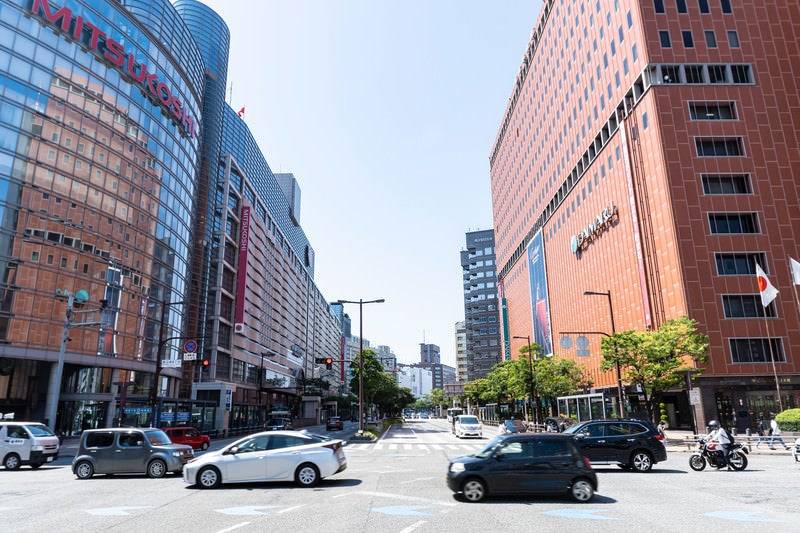

In [ ]:
from PIL import Image

pil_image = Image.open('test.jpg')
if pil_image.mode == 'RGBA':
    pil_image = pil_image.convert('RGB')

pil_image

# 推論テスト①

In [ ]:
input_text = 'Describe the image'

# プロンプト準備
inputs = processor.process(
    images=[pil_image],
    text=input_text
)
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

In [ ]:
%%time

# 推論
output = model.generate_from_batch(
    inputs,
    GenerationConfig(max_new_tokens=1024, stop_strings="<|endoftext|>"),
    tokenizer=processor.tokenizer
)

# デコード
generated_tokens = output[0,inputs['input_ids'].size(1):]
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
generated_text = generated_text.lstrip()

CPU times: user 13.4 s, sys: 337 ms, total: 13.8 s
Wall time: 14.5 s


In [ ]:
import textwrap
print('Prompt:', input_text)
print(textwrap.fill(generated_text, width=125))

Prompt: Describe the image
The image depicts a bustling city street scene, likely in Japan. The street is lined with tall buildings on both sides,
creating a canyon-like effect. On the left, there's a prominent Mitsukoshi department store with a curved glass facade.
Opposite it stands a large brown building with a red brick facade, featuring a sign that reads "Fujitsu."  The street is busy
with traffic, including cars, a motorcycle, and a white van. A crosswalk is visible in the foreground, with a pedestrian
waiting to cross. The sky is clear and blue, indicating it's a sunny day.  The scene is vibrant and colorful, with various
hues visible throughout - blues in the sky and on some building facades, reds on the Mitsukoshi sign and part of the opposite
building, browns on the Fujitsu building, and the diverse colors of the vehicles and other elements in the street.  Overall,
it's a lively urban snapshot that captures the essence of a busy Japanese city center, showcasing modern archite

# 推論テスト②

In [ ]:
input_text = 'Count the cars'

# プロンプト準備
inputs = processor.process(
    images=[pil_image],
    text=input_text
)
inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

In [ ]:
%%time

# 推論
output = model.generate_from_batch(
    inputs,
    GenerationConfig(max_new_tokens=1024, stop_strings="<|endoftext|>"),
    tokenizer=processor.tokenizer
)

# デコード
generated_tokens = output[0,inputs['input_ids'].size(1):]
generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)
generated_text = generated_text.lstrip()

CPU times: user 6.95 s, sys: 55.9 ms, total: 7 s
Wall time: 6.99 s


In [ ]:
import textwrap
print('Prompt:', input_text)
print(textwrap.fill(generated_text, width=125))

Prompt: Count the cars
Counting the <points x1="3.8" y1="83.2" x2="14.8" y2="85.7" x3="22.8" y3="82.3" x4="34.8" y4="87.0" x5="58.8" y5="80.8"
x6="65.8" y6="88.0" x7="77.8" y7="82.3" alt="cars">cars</points> shows a total of 7.


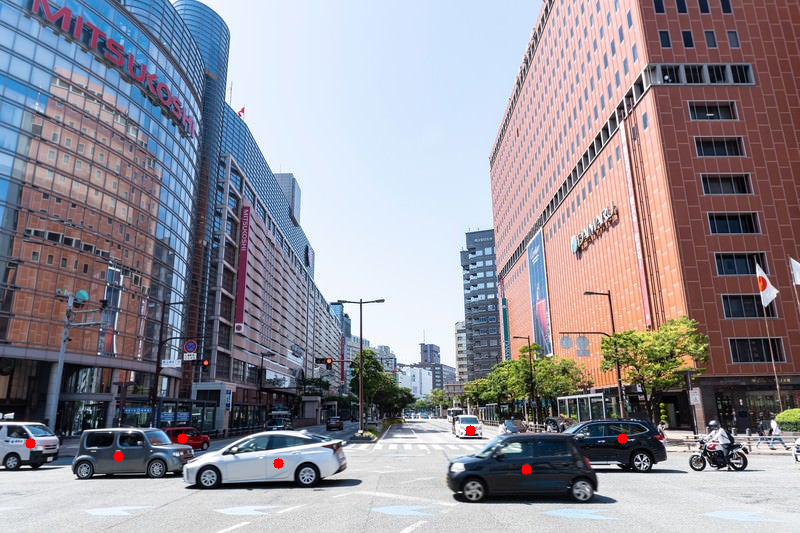

In [ ]:
import re
import copy

import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# 座標列抽出
pattern = r'x\d+="([\d.]+)" y\d+="([\d.]+)"'
matches = re.findall(pattern, generated_text)
coordinates = [(float(x), float(y)) for x, y in matches]

# 座標描画
cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
debug_image = copy.deepcopy(cv_image)
image_height, image_width = cv_image.shape[:2]
for x_percent, y_percent in matches:
    x_pixel = int(float(x_percent) / 100 * image_width)
    y_pixel = int(float(y_percent) / 100 * image_height)

    cv2.circle(debug_image, (x_pixel, y_pixel), radius=5, color=(0, 0, 255), thickness=-1)

cv2_imshow(debug_image)